# Machine Learning applied to MuJoCo environment

* ### Author: Mowibox (Ousmane THIONGANE)
* ### Date: November 4th, 2024

## Imports

In [247]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from envs.reacher_v6 import ReacherEnv
from tensorflow.keras.losses import MSE
from envs.reacher3_v6 import Reacher3Env
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, load_model, save_model

ModuleNotFoundError: No module named 'envs'

## I - Context 

The main goal of this project is to create a Machine Learning model and training it to learn Forward Kinematics (by configuring an input value for the position and orientation of the end effector of a robotic arm, we return the values of the joints that enable this point to be reached).

## II - Datasets generation

In this part, we will prepare the data to perform a regression the by generatinig the datasets.

### 1) 2D with 2 joints

Firstly, we record a sequence with by launching the script with the command line: `python3 run.py -env r2 -seed 2184503 -steps 100000 --log > 2R_2184503_100.csv`. This allows us to save the data in a csv and display it with pandas

The filename format is "\<model>\_\<seed>\_\<nr. of samples>.csv". Here 2R is the 2D with 2 joints model, 2184503 for the random seed 2184503 and 100 for 100k steps:

In [120]:
filepath_2R = r'data/2R_2184503_100.csv'
df_2R = pd.read_csv(filepath_2R, sep=";", header=0).copy()

display(df_2R.head(5))
df_2R.info()

,j0,j1,cos(j0),cos(j1),sin(j0),sin(j1),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,0.999,1.000,0.034,0.003,0.210,0.007,1.000,0.018
1,0.048,0.004,0.999,1.000,0.048,0.004,0.210,0.010,1.000,0.026
2,0.073,0.038,0.997,0.999,0.073,0.038,0.209,0.020,0.998,0.056
3,0.093,0.098,0.996,0.995,0.093,0.098,0.208,0.030,0.995,0.096
4,0.136,0.153,0.991,0.988,0.135,0.152,0.205,0.045,0.990,0.144


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    cos(j0)  100000 non-null  float64
 3    cos(j1)  100000 non-null  float64
 4    sin(j0)  100000 non-null  float64
 5    sin(j1)  100000 non-null  float64
 6    ee_x     100000 non-null  float64
 7    ee_y     100000 non-null  float64
 8    ee_qw    100000 non-null  float64
 9    ee_qz    100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


The .csv contains many informations about the simulation such as:
- The joints angles $j_0$, $j_1$
- The sine and the cosine of the joints angles: $\cos(j_0)$, $\sin(j_0)$, $\cos(j_1)$, $\sin(j_1)$
- The end-effector pose: $(x,y) = (ee_x, ee_y)$
- The end-effector orientation, based on quaternions: $q = (w,z) = (\cos(\frac{\theta_z}{2}), \sin(\frac{\theta_z}{2})) = ((ee_{qw})$, $(ee_{qz}))$ 



#### 1.a) Joint angles

In [121]:
X_2R = df_2R[[' cos(j0)', ' sin(j0)', ' cos(j1)', ' sin(j1)']].values

X_2R = pd.DataFrame(X_2R, columns=['cos(j0)', 'sin(j0)', 'cos(j1)', 'sin(j1)'])
display(X_2R.head(5))

,cos(j0),sin(j0),cos(j1),sin(j1)
0,0.999,0.034,1.000,0.003
1,0.999,0.048,1.000,0.004
2,0.997,0.073,0.999,0.038
3,0.996,0.093,0.995,0.098
4,0.991,0.135,0.988,0.152


#### 1.b) Fingertip position

In [122]:
y_2R_pos = df_2R[[' ee_x', ' ee_y']].values

#### 1.c) Fingertip orientation

In [123]:
y_2R_ori = df_2R[[' ee_qw', ' ee_qz']].values

Here, I choose to merge the end-effector position and orientation in one dataframe, so I can also try what will happened when all the outputs are provided to the model. 

In [124]:
y_2R = pd.concat([pd.DataFrame(y_2R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_2R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_2R.head(5))

,ee_x,ee_y,ee_qw,ee_qz
0,0.210,0.007,1.000,0.018
1,0.210,0.010,1.000,0.026
2,0.209,0.020,0.998,0.056
3,0.208,0.030,0.995,0.096
4,0.205,0.045,0.990,0.144


### 2) 2D with 3 joints 

The 3R robot .csv contains the following informations:
- The joints angles $j_0$, $j_1$, $j_2$ 
- The sine and the cosine of the joints angles: $\cos(j_0)$, $\sin(j_0)$, $\cos(j_1)$, $\sin(j_1)$, $\cos(j_2)$, $\sin(j_2)$
- The end-effector pose: $(x,y) = (ee_x, ee_y)$
- The end-effector orientation, based on quaternions: $q = (w,z) = (\cos(\frac{\theta_z}{2}), \sin(\frac{\theta_z}{2})) = ((ee_{qw})$, $(ee_{qz}))$ 


In [125]:
filepath_3R = r'data/3R_2184503_100.csv'
df_3R = pd.read_csv(filepath_3R, sep=";", header=0).copy()

display(df_3R.head(5))
df_3R.info()

,j0,j1,j2,cos(j0),cos(j1),cos(j2),sin(j0),sin(j1),sin(j2),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,-0.002,0.999,1.000,1.000,0.034,0.003,-0.002,0.310,0.011,1.000,0.017
1,0.047,0.004,-0.003,0.999,1.000,1.000,0.047,0.004,-0.003,0.310,0.015,1.000,0.024
2,0.105,0.001,-0.008,0.994,1.000,1.000,0.105,0.001,-0.008,0.308,0.032,0.999,0.049
3,0.222,-0.009,-0.014,0.975,1.000,1.000,0.220,-0.009,-0.014,0.303,0.065,0.995,0.099
4,0.369,-0.042,-0.041,0.933,0.999,0.999,0.361,-0.042,-0.041,0.293,0.099,0.990,0.143


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    cos(j0)  100000 non-null  float64
 4    cos(j1)  100000 non-null  float64
 5    cos(j2)  100000 non-null  float64
 6    sin(j0)  100000 non-null  float64
 7    sin(j1)  100000 non-null  float64
 8    sin(j2)  100000 non-null  float64
 9    ee_x     100000 non-null  float64
 10   ee_y     100000 non-null  float64
 11   ee_qw    100000 non-null  float64
 12   ee_qz    100000 non-null  float64
dtypes: float64(13)
memory usage: 9.9 MB


The processing of the data is basically the same as on the previous part:

#### 2.a) Joint angles

In [126]:
X_3R = df_3R[[' cos(j0)', ' sin(j0)', ' cos(j1)', ' sin(j1)', ' cos(j2)', ' sin(j2)']].values
X_3R = pd.DataFrame(X_3R, columns=['cos(j0)', 'sin(j0)', 'cos(j1)', 'sin(j1)', 'cos(j2)', 'sin(j2)'])
display(X_3R.head(5))

,cos(j0),sin(j0),cos(j1),sin(j1),cos(j2),sin(j2)
0,0.999,0.034,1.000,0.003,1.000,-0.002
1,0.999,0.047,1.000,0.004,1.000,-0.003
2,0.994,0.105,1.000,0.001,1.000,-0.008
3,0.975,0.220,1.000,-0.009,1.000,-0.014
4,0.933,0.361,0.999,-0.042,0.999,-0.041


#### 2.b) Fingertip position

In [127]:
y_3R_pos = df_3R[[' ee_x', ' ee_y']].values

#### 2.c) Fingertip orientation

In [128]:
y_3R_ori = df_3R[[' ee_qw', ' ee_qz']].values

In [129]:
y_3R = pd.concat([pd.DataFrame(y_3R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_3R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_3R.head(5))

,ee_x,ee_y,ee_qw,ee_qz
0,0.310,0.011,1.000,0.017
1,0.310,0.015,1.000,0.024
2,0.308,0.032,0.999,0.049
3,0.303,0.065,0.995,0.099
4,0.293,0.099,0.990,0.143


### 3) 3D with 5 joints

Since the 5R robot .csv is a 3D-case, the end-effector pose will contain more components:
- The joints angles $j_0$, $j_1$, $j_2$, $j_3$, $j_4$ 
- The sine and the cosine of the joints angles: $\cos(j_0)$, $\sin(j_0)$, $\cos(j_1)$, $\sin(j_1)$, $\cos(j_2)$, $\sin(j_2)$, $\cos(j_3)$, $\sin(j_3)$, $\cos(j_4)$, $\sin(j_4)$
- The end-effector pose: $(x,y,z) = (ee_x, ee_y, ee_z)$
- The end-effector orientation, based on quaternions: $q = (w,x,y,z) = (\cos(\frac{\theta}{2}), \sin(\frac{\theta}{2}), \sin(\frac{\theta}{2}), \sin(\frac{\theta}{2})) = ((ee_{qw}), (ee_{qx}), (ee_{qy}), (ee_{qz}))$ 


In [130]:
filepath_5R = r'data/5R_2184503_100.csv'
df_5R = pd.read_csv(filepath_5R, sep=";", header=0).copy()

display(df_5R.head(5))
df_5R.info()

,j0,j1,j2,j3,j4,cos(j0),cos(j1),cos(j2),cos(j3),cos(j4),...,sin(j2),sin(j3),sin(j4),ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.0,...,0.000,0.000,0.000,0.000,0.000,0.590,1.000,0.000,0.000,0.000
1,0.014,0.001,-0.001,0.031,-0.005,1.000,1.000,1.000,1.000,1.0,...,-0.001,0.031,-0.005,0.007,0.001,0.590,1.000,-0.003,0.016,0.007
2,0.037,0.031,-0.005,0.096,-0.011,0.999,1.000,1.000,0.995,1.0,...,-0.005,0.096,-0.011,0.035,0.003,0.588,0.998,-0.007,0.061,0.019
3,0.034,0.067,-0.049,0.146,0.014,0.999,0.998,0.999,0.989,1.0,...,-0.049,0.146,0.014,0.048,-0.000,0.587,0.996,0.006,0.082,0.016
4,0.036,0.074,-0.157,0.160,0.030,0.999,0.997,0.988,0.987,1.0,...,-0.156,0.160,0.030,0.017,-0.003,0.589,0.999,0.014,0.039,0.017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    j3       100000 non-null  float64
 4    j4       100000 non-null  float64
 5    cos(j0)  100000 non-null  float64
 6    cos(j1)  100000 non-null  float64
 7    cos(j2)  100000 non-null  float64
 8    cos(j3)  100000 non-null  float64
 9    cos(j4)  100000 non-null  float64
 10   sin(j0)  100000 non-null  float64
 11   sin(j1)  100000 non-null  float64
 12   sin(j2)  100000 non-null  float64
 13   sin(j3)  100000 non-null  float64
 14   sin(j4)  100000 non-null  float64
 15   ee_x     100000 non-null  float64
 16   ee_y     100000 non-null  float64
 17   ee_z     100000 non-null  float64
 18   ee_qw    100000 non-null  float64
 19   ee_qx    100000 non-null  float64
 20   ee_q

#### 3.a) Joint angles 

In [131]:
X_5R = df_5R[[' cos(j0)', ' sin(j0)', ' cos(j1)', ' sin(j1)', ' cos(j2)', ' sin(j2)', ' cos(j3)', ' sin(j3)', ' cos(j4)', ' sin(j4)']].values

X_5R = pd.DataFrame(X_5R, columns=['cos(j0)', 'sin(j0)', 'cos(j1)', 'sin(j1)', 'cos(j2)', 'sin(j2)', 'cos(j3)', 'sin(j3)', 'cos(j4)', 'sin(j4)'])
display(X_5R.head(5))

,cos(j0),sin(j0),cos(j1),sin(j1),cos(j2),sin(j2),cos(j3),sin(j3),cos(j4),sin(j4)
0,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.0,0.000
1,1.000,0.014,1.000,0.001,1.000,-0.001,1.000,0.031,1.0,-0.005
2,0.999,0.037,1.000,0.031,1.000,-0.005,0.995,0.096,1.0,-0.011
3,0.999,0.034,0.998,0.067,0.999,-0.049,0.989,0.146,1.0,0.014
4,0.999,0.036,0.997,0.074,0.988,-0.156,0.987,0.160,1.0,0.030


#### 3.b) Fingertip position

In [132]:
y_5R_pos = df_5R[[' ee_x', ' ee_y', ' ee_z']].values

#### 3.c) Fingertip orientation

In [133]:
y_5R_ori = df_5R[[' ee_qw', ' ee_qx', ' ee_qy', ' ee_qz']].values

In [134]:
y_5R = pd.concat([pd.DataFrame(y_5R_pos, columns=['ee_x', 'ee_y', "ee_z"]), 
                         pd.DataFrame(y_5R_ori, columns=['ee_qw', 'ee_qx', 'ee_qy', 'ee_qz'])], axis=1)

display(y_5R.head(5))

,ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.590,1.000,0.000,0.000,0.000
1,0.007,0.001,0.590,1.000,-0.003,0.016,0.007
2,0.035,0.003,0.588,0.998,-0.007,0.061,0.019
3,0.048,-0.000,0.587,0.996,0.006,0.082,0.016
4,0.017,-0.003,0.589,0.999,0.014,0.039,0.017


## III - Learning Forward Kinematics

### 1) 2D with 2 joints

We are dividing the dataset to randomly take 80% of the data for training the model, and 20% for testing. Let's try first by giving only the position:

In [135]:
X_2R_train, X_2R_test, y_2R_train, y_2R_test = train_test_split(X_2R, y_2R_pos, test_size=0.2, random_state=2184503)
print(X_2R_train.shape, y_2R_train.shape)
print(y_2R_test.shape, y_2R_test.shape)

(80000, 4) (80000, 2)
(20000, 2) (20000, 2)


For a more challenging task, we can train our model by taking a subset of the main dataset e.g. e are only taking a certain percentage of samples from the whole dataset:

In [136]:
percentage = 0.1

subset_size_train = int(len(X_2R_train)*percentage)
subset_size_test = int(len(X_2R_test)*percentage)

X_2R_train = X_2R_train[:subset_size_train]
y_2R_train = y_2R_train[:subset_size_train]
X_2R_test = X_2R_test[:subset_size_test]
y_2R_test = y_2R_test[:subset_size_test]

print(X_2R_train.shape, y_2R_train.shape)
print(y_2R_test.shape, y_2R_test.shape)

(8000, 4) (8000, 2)
(2000, 2) (2000, 2)


##### Model definition 

To define our model, we create a simple neural network with a few hidden layers and ReLU as the activation function. The output layer contains a linear activation function.

In [137]:
model_2R = Sequential()
model_2R.add(Input((X_2R_train.shape[1],)))
model_2R.add(Dense(32, activation="relu"))
model_2R.add(Dense(8, activation="relu"))
model_2R.add(Dense(y_2R_train.shape[1], activation="linear"))

model_2R.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 442 (1.73 KB)

 Trainable params: 442 (1.73 KB)

 Non-trainable params: 0 (0.00 B)

##### Loss function & optimizer

The MSE is commonly used as a loss function in a regression problem, especially in our case where we have no outliers that would impair model performance. 

That's why I've chosen to input only the cosines and sines of the joints because by directly use the angle values of the joints, the problem is that values can be close but still have a large square error. 

For example, $0$ and $2\pi$ are values which are very close together on the trigonometric circle, but this will result on a large error in terms of squared diffrence.

I also tried to compute a custom loss based on the Euclidian distance. Noting $\theta$ and $\phi$ respectively the actual and predicted angles, the expression of the Euclidian distance will be:

$d²_E(\theta, \phi)=(\cos\theta-\cos\phi)²+(\sin\theta-\sin\phi)²$

$d²_E(\theta, \phi)=\cos²\theta-2\cos\theta \cos\phi + \cos²\phi+\sin²\theta-2\sin\theta\sin\phi + \sin²\phi$

$d²_E(\theta, \phi)=2-2\cos(\theta-\phi)$

By using this function, we just need to provide the angles values to the model without their cosines and sines.

In [138]:
def angular_loss(theta, phi):
    """
    Computes the squared Euclidean distance on the unit circle.
    
    
    @param theta: Ground truth angles (in radians).
    @param phi: Predicted angles (in radians).

    """
    theta = tf.convert_to_tensor(theta)
    phi = tf.convert_to_tensor(phi)

    # Compute the cosine of the angular differences
    loss = 2 - 2 * tf.cos(theta - phi)

    return K.mean(loss)

In [139]:
model_2R.compile(loss=MSE, optimizer=Adam(learning_rate=0.001))

##### Solver - Training phase

In [140]:
epochs = 30
history_2R = model_2R.fit(X_2R_train, y_2R_train,
                    epochs=epochs,
                    validation_data=(X_2R_test, y_2R_test),
                    verbose=1)

print(f"== Final loss ==\nTrain: {history_2R.history['loss'][-1]}\nTest: {history_2R.history['val_loss'][-1]}")

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0176 - val_loss: 0.0026
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - val_loss: 7.3420e-04
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7863e-04 - val_loss: 3.1659e-04
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5335e-04 - val_loss: 1.6933e-04
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4572e-04 - val_loss: 1.0934e-04
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5113e-05 - val_loss: 7.6874e-05
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2232e-05 - val_loss: 6.3409e-05
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9252e-05 - val_loss: 5.5704e-05
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2278e-05 - val_loss: 4.8292e-05
Epoch 10/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4338e-05 - val_loss: 4.2771e-05
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2222e-05

In [141]:
def displayLearningCurve(history, epochs: int):
    """
    Displays the model loss

    @param history: The model history
    @param epochs: The number of epochs
    """
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title("Model loss")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.tight_layout()
    plt.show()

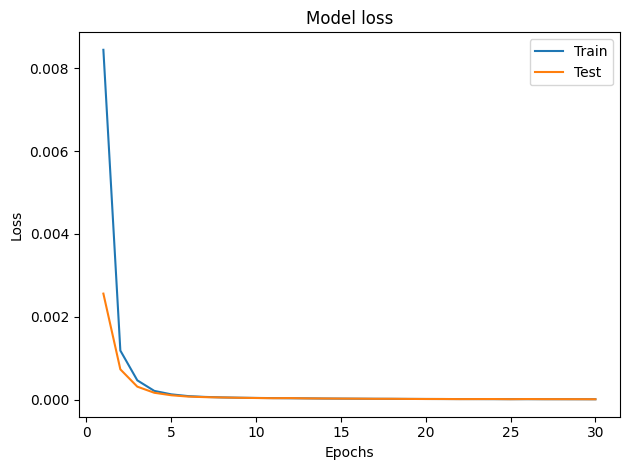

In [142]:
displayLearningCurve(history=history_2R, 
                    epochs=epochs)

##### Hyper-parameter search

##### Testing the model - Machine Learning vs Traditionnal method

In [217]:
def FK(model, theta):
    """
    Predicts the Forward Kinematics for a defined set of angles
    @param model: The machine learning model
    @param theta: The tensor of angle inputs
    """

    theta = tf.convert_to_tensor(theta, dtype=tf.float32) 
    n = theta.shape[0]
    if n == 2:    # 2R Robot
        features = tf.stack([tf.cos(theta[0]), tf.sin(theta[0]),
                             tf.cos(theta[1]), tf.sin(theta[1])])
    elif n == 3:  # 3R Robot
        features = tf.stack([tf.cos(theta[0]), tf.sin(theta[0]),
                             tf.cos(theta[1]), tf.sin(theta[1]),
                             tf.cos(theta[2]), tf.sin(theta[2])])
    elif n == 5:  # 5R Robot
        features = tf.stack([tf.cos(theta[0]), tf.sin(theta[0]),
                             tf.cos(theta[1]), tf.sin(theta[1]),
                             tf.cos(theta[2]), tf.sin(theta[2]),
                             tf.cos(theta[3]), tf.sin(theta[3]),
                             tf.cos(theta[4]), tf.sin(theta[4])])
    else:
        raise ValueError("Error! size of theta must be 2, 3, or 5!")
    
    # Reshape to batch size 1
    t = tf.reshape(features, shape=(1, features.shape[0]))
    out = model(t)
    
    # Reshape to the appropriate output vector
    output_shape = model.output_shape[1]
    out = tf.reshape(out, shape=(output_shape,))

    return out

In [144]:
THETA_LST = [(0, 0), (np.pi/2, np.pi/2), (np.pi/2, np.pi/4)]

for theta in THETA_LST:
    ee_x_pred, ee_y_pred = FK(model_2R, theta)
    print(f"Example with (j0, j1) = {theta}")
    print(f"End-effector predicted X-position: {ee_x_pred}")
    print(f"End-effector predicted Y-position: {ee_y_pred}")
    print("\n")

Features shape: (4,), n: 2
Example with (j0, j1) = (0, 0)
End-effector predicted X-position: 0.20988190174102783
End-effector predicted Y-position: 0.006099209189414978


Features shape: (4,), n: 2
Example with (j0, j1) = (1.5707963267948966, 1.5707963267948966)
End-effector predicted X-position: -0.10930658876895905
End-effector predicted Y-position: 0.1074385941028595


Features shape: (4,), n: 2
Example with (j0, j1) = (1.5707963267948966, 0.7853981633974483)
End-effector predicted X-position: -0.07559601962566376
End-effector predicted Y-position: 0.182439923286438




In [145]:
    # j0, j1 = theta
    # A = np.array([
    # [np.cos(j0), np.cos(j0 + j1)],
    # [np.sin(j0), np.sin(j0 + j1)]
    # ])

    # print(A)
    # print(np.linalg.inv(A))

In [146]:
def dispFK_2R(model, theta):
    """
    Plots the Forward Kinematics 2R comparison between Analytical method and ML model.

    model: The end-effector predicted position
    theta: The joint angles for the 2R robot
    """


    ee_x_pred, ee_y_pred = model 

    j0, j1 = theta
    # Based on the specified robot parameters
    l1 = 0.1  # First link
    l2 = 0.1  # Second link
    
    # FK Analytical equations
    x1 = l1 * np.cos(j0)
    y1 = l1 * np.sin(j0)
    x2 = x1 + l2 * np.cos(j0 + j1)
    y2 = y1 + l2 * np.sin(j0 + j1)

    plt.figure(figsize=(5, 5))
    
    plt.plot([0, x1], [0, y1], 'c-', marker='o', label="Link 1 (Analytical)")
    plt.plot([x1, x2], [y1, y2], 'cyan', marker='o', label="Link 2 (Analytical)")

    # Plot ML-predicted end-effector
    plt.plot(ee_x_pred, ee_y_pred, 'mx', label="End-Effector (Model Prediction)")

    plt.xlim(-0.25, 0.25)
    plt.ylim(-0.25, 0.25)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("2R Analytical and Model Prediciton Comparison")
    plt.grid()
    plt.legend()
    plt.show()

Features shape: (4,), n: 2


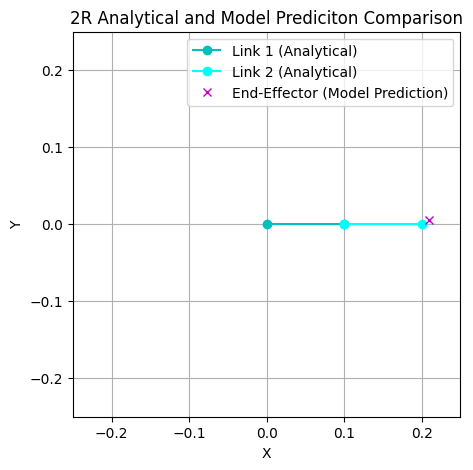

Features shape: (4,), n: 2


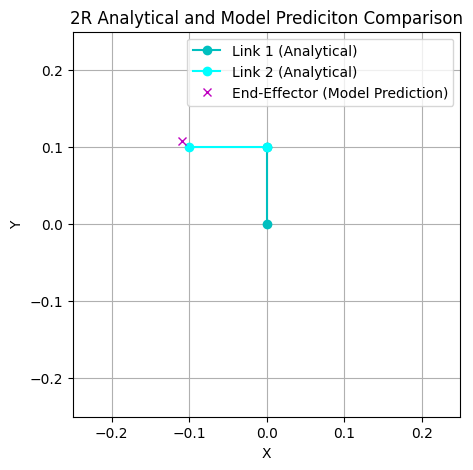

Features shape: (4,), n: 2


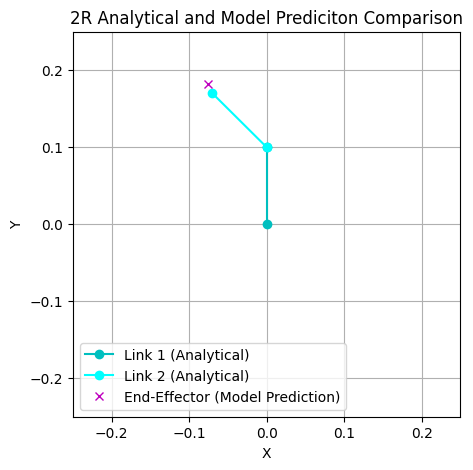

In [147]:
for theta in THETA_LST:
    result_model = FK(model_2R, theta)  
    dispFK_2R(result_model, theta)

In [148]:
y_pred_test = model_2R.predict(X_2R_test)
print(f"Mean absolute error: {mean_absolute_error(y_2R_test, y_pred_test)}")
print(f"Mean absolute error (%): {mean_absolute_percentage_error(y_2R_test, y_pred_test)}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean absolute error: 0.0027093232881231274
Mean absolute error (%): 60497757470.83911


##### Jacobian matrix

In [149]:
@tf.function
def FK_Jacobian_pred(model, x):
    """
    Computes the Forward Kinematics Jacobian matrix
    
    @param model: The machine learning model
    @param x: The tuple of angle inputs
    """
    theta = tf.convert_to_tensor(x, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(theta)
        y = FK(model, theta)
        n = theta.shape[0]
        output_shape = model.output_shape[0]

        # Removing the quaternion part for the Jacobian computation
        if n == 2 or n == 3:
            y = y if output_shape == 2 else y[:2]
        elif n == 5:
            y = y if output_shape == 3 else y[:3]
        else:
            raise ValueError("Error! size of theta must be 2, 3, or 5!")
        
    return tape.jacobian(y, theta)


def FK_Jacobian_analytic_2R(theta):
    """
    Computes the Analytic Forward Kinematics Jacobian matrix
    @param theta: The tuple of angle inputs
    """
    l1, l2, = 0.1, 0.1
    j0, j1 = theta
    analytical_J = np.array([[-l1*np.sin(j0)-l2*np.sin(j0+j1), -l2*np.sin(j0+j1)],
                             [ l1*np.cos(j0)+l2*np.cos(j0+j1),  l2*np.cos(j0+j1)]])
    return analytical_J

In [150]:
theta = [np.pi/4, np.pi/2]  

learned_J = FK_Jacobian_pred(model_2R, theta)
print(f"Jacobian Matrix predicted:\n{learned_J}")

analytical_J = FK_Jacobian_analytic_2R(theta)
print(f"Jacobian Matrix analytical:\n{learned_J}")


Features shape: (4,), n: 2
Jacobian Matrix predicted:
[[-0.13264307 -0.11719664]
 [-0.04224917 -0.12996936]]
Jacobian Matrix analytical:
[[-0.13264307 -0.11719664]
 [-0.04224917 -0.12996936]]


### 2) 2D with 3 joints

In [151]:
X_3R_train, X_3R_test, y_3R_train, y_3R_test = train_test_split(X_3R, y_3R_pos, test_size=0.2, random_state=2184503)
print(X_3R_train.shape, y_3R_train.shape)
print(y_3R_test.shape, y_3R_test.shape)

(80000, 6) (80000, 2)
(20000, 2) (20000, 2)


In [152]:
percentage = 0.1

subset_size_train = int(len(X_3R_train)*percentage)
subset_size_test = int(len(X_3R_test)*percentage)

X_3R_train = X_3R_train[:subset_size_train]
y_3R_train = y_3R_train[:subset_size_train]
X_3R_test = X_3R_test[:subset_size_test]
y_3R_test = y_3R_test[:subset_size_test]

print(X_2R_train.shape, y_2R_train.shape)
print(y_2R_test.shape, y_2R_test.shape)

(8000, 4) (8000, 2)
(2000, 2) (2000, 2)


In [153]:
model_3R = Sequential()
model_3R.add(Input((X_3R_train.shape[1],)))
model_3R.add(Dense(64, activation="relu"))
model_3R.add(Dense(16, activation="relu"))
model_3R.add(Dense(y_3R_train.shape[1], activation="linear"))
model_3R.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,522 (5.95 KB)

 Trainable params: 1,522 (5.95 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
model_3R.compile(loss=MSE, optimizer=Adam(learning_rate=0.001))

epochs = 30
history_3R = model_3R.fit(X_3R_train, y_3R_train,
                    epochs=epochs,
                    validation_data=(X_3R_test, y_3R_test),
                    verbose=1)

print(f"== Final loss ==\nTrain: {history_3R.history['loss'][-1]}\nTest: {history_3R.history['val_loss'][-1]}")

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0253 - val_loss: 0.0016
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 5.8240e-04
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0758e-04 - val_loss: 3.7067e-04
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.3329e-04 - val_loss: 2.9581e-04
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6842e-04 - val_loss: 2.2659e-04
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1862e-04 - val_loss: 2.0144e-04
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8528e-04 - val_loss: 1.7117e-04
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5934e-04 - val_loss: 1.5977e-04
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3943e-04 - val_loss: 1.3730e-04
Epoch 10/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2563e-04 - val_loss: 1.3410e-04
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1454e-04

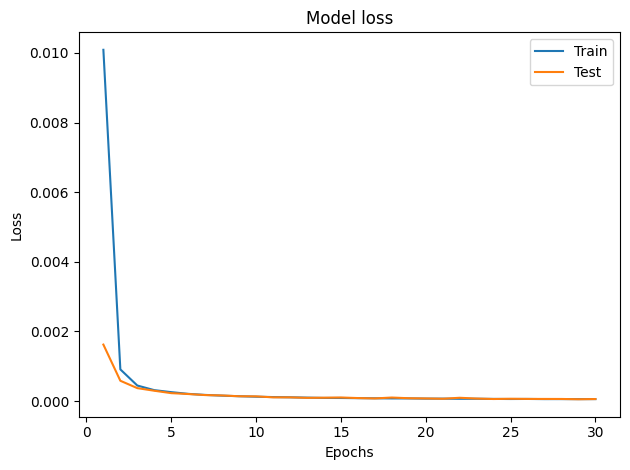

In [155]:
displayLearningCurve(history=history_3R, 
                    epochs=epochs)

In [156]:
THETA_LST = [(0, 0, 0), (np.pi/4, np.pi/4, np.pi/4), (0, np.pi/2, np.pi/2)]

for theta in THETA_LST:
    ee_x_pred, ee_y_pred = FK(model_3R, theta)
    print(f"Example with (j0, j1, j2) = {theta}")
    print(f"End-effector predicted X-position: {ee_x_pred}")
    print(f"End-effector predicted Y-position: {ee_y_pred}")
    print("\n")

Features shape: (6,), n: 3
Example with (j0, j1, j2) = (0, 0, 0)
End-effector predicted X-position: 0.3265880048274994
End-effector predicted Y-position: -0.00430481880903244


Features shape: (6,), n: 3
Example with (j0, j1, j2) = (0.7853981633974483, 0.7853981633974483, 0.7853981633974483)
End-effector predicted X-position: 0.0014855116605758667
End-effector predicted Y-position: 0.23726001381874084


Features shape: (6,), n: 3
Example with (j0, j1, j2) = (0, 1.5707963267948966, 1.5707963267948966)
End-effector predicted X-position: -0.0005520917475223541
End-effector predicted Y-position: 0.09318237006664276




In [157]:
def dispFK_3R(model, theta):
    """
    Plots the Forward Kinematics 3R comparison between Analytical method and ML model.

    model: The end-effector predicted position
    theta: The joint angles for the 3R robot
    """


    ee_x_pred, ee_y_pred = model 

    j0, j1, j2 = theta
    # Based on the specified robot parameters
    l1 = 0.1  # First link
    l2 = 0.1  # Second link
    l3 = 0.1  # Third link
    
    # FK Analytical equations
    x1 = l1 * np.cos(j0)
    y1 = l1 * np.sin(j0)
    x2 = x1 + l2 * np.cos(j0 + j1)
    y2 = y1 + l2 * np.sin(j0 + j1)
    x3 = l1*np.cos(j0) + l2 * np.cos(j0 + j1) + l3*np.cos(j0 + j1 + j2)
    y3 = l1*np.sin(j0) + l2 * np.sin(j0 + j1) + l3*np.sin(j0 + j1 + j2)

    plt.figure(figsize=(5, 5))
    
    plt.plot([0, x1], [0, y1], 'r-', marker='o', label="Link 1 (Analytical)")
    plt.plot([x1, x2], [y1, y2], 'orange', marker='o', label="Link 2 (Analytical)")
    plt.plot([x2, x3], [y2, y3], 'gold', marker='o', label="Link 3 (Analytical)")

    # Plot ML-predicted end-effector
    plt.plot(ee_x_pred, ee_y_pred, 'mx', label="End-Effector (Model Prediction)")

    plt.xlim(-0.35, 0.35)
    plt.ylim(-0.35, 0.35)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("3R Analytical and Model Prediciton Comparison")
    plt.grid()
    plt.legend()
    plt.show()

Features shape: (6,), n: 3


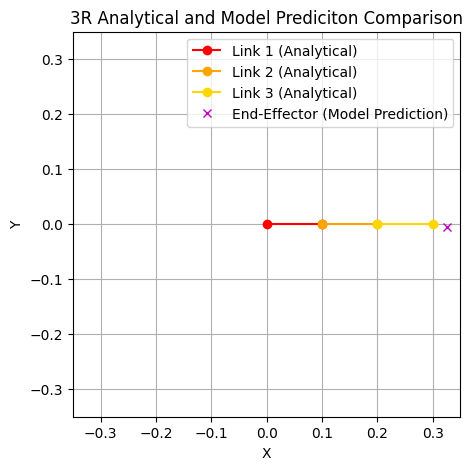

Features shape: (6,), n: 3


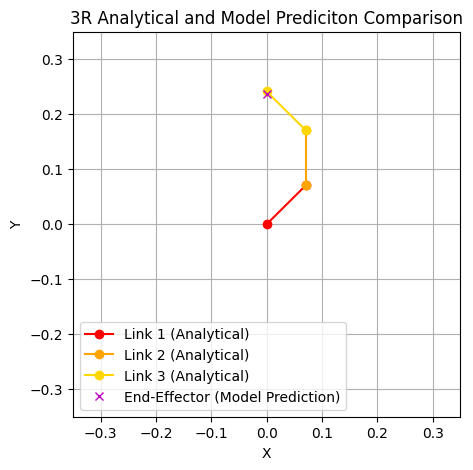

Features shape: (6,), n: 3


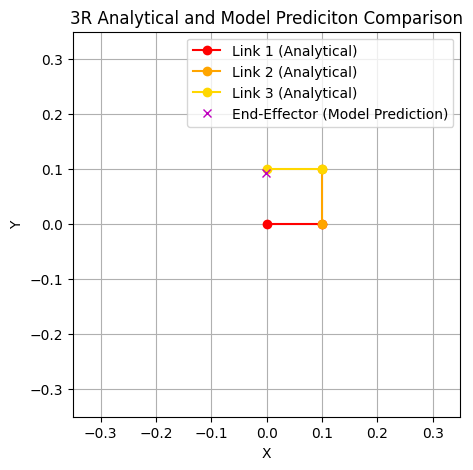

In [158]:
for theta in THETA_LST:
    result_model = FK(model_3R, theta)  
    dispFK_3R(result_model, theta)

In [159]:
def FK_Jacobian_analytic_3R(theta):
    """
    Computes the Analytic Forward Kinematics Jacobian matrix for a 3R robot
    @param theta: The tuple of angle inputs
    """
    l1, l2, l3 = 0.1, 0.1, 0.1  
    theta1, theta2, theta3 = theta

    analytical_J = np.array([
        [-l1*np.sin(theta1) - l2*np.sin(theta1 + theta2) - l3*np.sin(theta1 + theta2 + theta3),
         -l2*np.sin(theta1 + theta2) - l3*np.sin(theta1 + theta2 + theta3),
         -l3*np.sin(theta1 + theta2 + theta3)],
        
        [l1*np.cos(theta1) + l2*np.cos(theta1 + theta2) + l3*np.cos(theta1 + theta2 + theta3),
         l2*np.cos(theta1 + theta2) + l3*np.cos(theta1 + theta2 + theta3),
         l3*np.cos(theta1 + theta2 + theta3)]
    ])
    
    return analytical_J

In [160]:
theta = [np.pi/4, np.pi/2, np.pi/4]  

learned_J = FK_Jacobian_pred(model_3R, theta)
print(f"Jacobian Matrix predicted:\n{learned_J}")

analytical_J = FK_Jacobian_pred(model_3R, theta)
print(f"Jacobian Matrix predicted:\n{analytical_J}")

Features shape: (6,), n: 3
Jacobian Matrix predicted:
[[-0.17037201  0.01689133  0.06698508]
 [-0.09612188 -0.1765649  -0.13121599]]
Jacobian Matrix predicted:
[[-0.17037201  0.01689133  0.06698508]
 [-0.09612188 -0.1765649  -0.13121599]]


### 3) 3D with 5 joints

In [161]:
X_5R_train, X_5R_test, y_5R_train, y_5R_test = train_test_split(X_5R, y_5R_pos, test_size=0.2, random_state=2184503)
print(X_5R_train.shape, y_5R_train.shape)
print(y_5R_test.shape, y_5R_test.shape)

(80000, 10) (80000, 3)
(20000, 3) (20000, 3)


In [162]:
percentage = 0.8

subset_size_train = int(len(X_5R_train)*percentage)
subset_size_test = int(len(X_5R_test)*percentage)

X_5R_train = X_5R_train[:subset_size_train]
y_5R_train = y_5R_train[:subset_size_train]
X_5R_test = X_5R_test[:subset_size_test]
y_5R_test = y_5R_test[:subset_size_test]

print(X_5R_train.shape, y_5R_train.shape)
print(y_5R_test.shape, y_5R_test.shape)

(64000, 10) (64000, 3)
(16000, 3) (16000, 3)


In [163]:
model_5R = Sequential()
model_5R.add(Input((X_5R_train.shape[1],)))
model_5R.add(Dense(128, activation="relu"))
model_5R.add(Dense(32, activation="relu"))
model_5R.add(Dense(y_5R_train.shape[1], activation="linear"))
model_5R.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,635 (22.01 KB)

 Trainable params: 5,635 (22.01 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
model_5R.compile(loss=MSE, optimizer=Adam(learning_rate=0.001))

epochs = 50
history_5R = model_5R.fit(X_5R_train, y_5R_train,
                    epochs=epochs,
                    validation_data=(X_5R_test, y_5R_test),
                    verbose=1)

print(f"== Final loss ==\nTrain: {history_5R.history['loss'][-1]}\nTest: {history_5R.history['val_loss'][-1]}")

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0070 - val_loss: 4.7681e-04
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.8490e-04 - val_loss: 2.6307e-04
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.5226e-04 - val_loss: 2.1415e-04
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.0513e-04 - val_loss: 2.0797e-04
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.7479e-04 - val_loss: 1.5928e-04
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.5143e-04 - val_loss: 1.3597e-04
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.3794e-04 - val_loss: 1.2859e-04
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.2629e-04 - val_loss: 9.8104e-05
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.1011e-04 - val_loss: 1.0825e-04
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.0653e-04 - val_loss: 1.0867e-04
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 

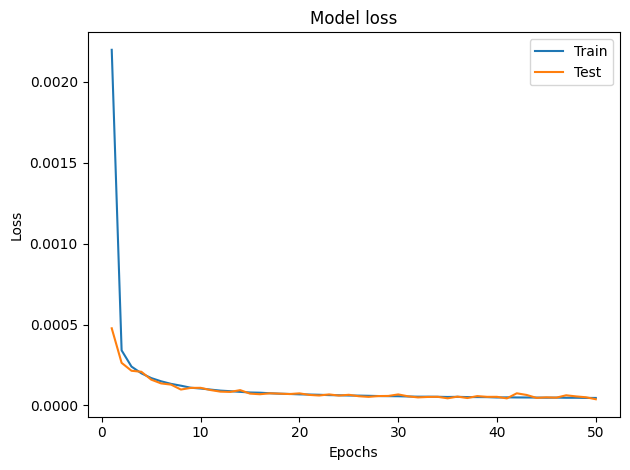

In [165]:
displayLearningCurve(history=history_5R, 
                    epochs=epochs)

In [166]:
THETA_LST = [(0, 0, 0, 0, 0), (np.pi/4, np.pi/4, np.pi/4, np.pi/4, -np.pi/2)]

for theta in THETA_LST:
    ee_x_pred, ee_y_pred, ee_z_pred = FK(model_5R, theta)
    print(f"Example with (j0, j1, j2, j3, j4) = {theta}")
    print(f"End-effector predicted X-position: {ee_x_pred}")
    print(f"End-effector predicted Y-position: {ee_y_pred}")
    print(f"End-effector predicted Z-position: {ee_z_pred}")
    print("\n")

Features shape: (10,), n: 5
Example with (j0, j1, j2, j3, j4) = (0, 0, 0, 0, 0)
End-effector predicted X-position: -0.004908852279186249
End-effector predicted Y-position: -0.009844806045293808
End-effector predicted Z-position: 0.5867618322372437


Features shape: (10,), n: 5
Example with (j0, j1, j2, j3, j4) = (0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, -1.5707963267948966)
End-effector predicted X-position: 0.10974463820457458
End-effector predicted Y-position: 0.2751878798007965
End-effector predicted Z-position: 0.1310729682445526




In [167]:
theta = [np.pi/4, np.pi/2, np.pi/4, np.pi/4, np.pi/4]  

learned_J = FK_Jacobian_pred(model_5R, theta)
print(f"Jacobian Matrix predicted:\n{learned_J}")

Features shape: (10,), n: 5
Jacobian Matrix predicted:
[[-0.05395681 -0.16118631 -0.1399957  -0.10769764  0.0599313 ]
 [ 0.18289864 -0.21725413 -0.21306309 -0.14228019 -0.07412528]
 [ 0.01638466 -0.11233693 -0.05219069  0.00572834  0.06711082]]


## IV - Inverse Kinematics 

In [ ]:
def IK_Newton_Raphson(target_pos, initial_theta, model, max_iters=100, tolerance=1e-6):
    '''
    Computes The Inverse Kinematics using the Newton-Raphson method for a 2R robot.

    @param target_pos: Desired end-effector position (x, y)
    @param initial_theta: The initial value of joint angles
    @param model: The machine learning model
    @param max_iters: The maximum number of iterations
    @param tolerance: The tolerance for convergence
    '''
    theta = np.array(initial_theta, dtype=np.float32)
    for step in range(max_iters):
        current_pos = FK(model, theta)[:2]
        print(f"===== Step n°{step} =====")
        print(f"Current Position: {current_pos}")
        print(f"Intermediate joint angles: {theta}\n")

        error = target_pos - current_pos
        error = tf.reshape(error, (-1, 1))

        # Checking convergence
        if np.linalg.norm(error) < tolerance:
            break

        J = FK_Jacobian_pred(model, theta)

        dtheta = (tf.linalg.pinv(J) @ error)
        theta += dtheta.numpy().flatten()

    print(20*"=")
    print(f"Converegence reached in {step} steps")
    print(f"Computed joint angles for target position {target_pos}: (j0, j1) = {theta}")

    return theta

### 1) 2D with 2 joints

===== Step n°0 =====
Current Position: [-0.00460488  0.15092191]
Intermediate joint angles: [0.7853982 1.5707964]

===== Step n°1 =====
Current Position: [-0.0528594   0.02855955]
Intermediate joint angles: [-2.289244   3.7314825]

===== Step n°2 =====
Current Position: [-0.05137512 -0.0889361 ]
Intermediate joint angles: [-3.2757733  2.1774187]

===== Step n°3 =====
Current Position: [-0.03946508  0.04522176]
Intermediate joint angles: [-2.6406574  3.7302203]

===== Step n°4 =====
Current Position: [-0.04094401 -0.07293057]
Intermediate joint angles: [-3.3561487  2.3380857]

===== Step n°5 =====
Current Position: [-0.04375637  0.05673426]
Intermediate joint angles: [-2.748228  3.833953]

===== Step n°6 =====
Current Position: [-0.03362528 -0.07987604]
Intermediate joint angles: [-3.2277274  2.3181617]

===== Step n°7 =====
Current Position: [-0.02591506  0.02334371]
Intermediate joint angles: [-2.4439373  3.523632 ]

===== Step n°8 =====
Current Position: [-0.17124666 -0.10997335]
Int

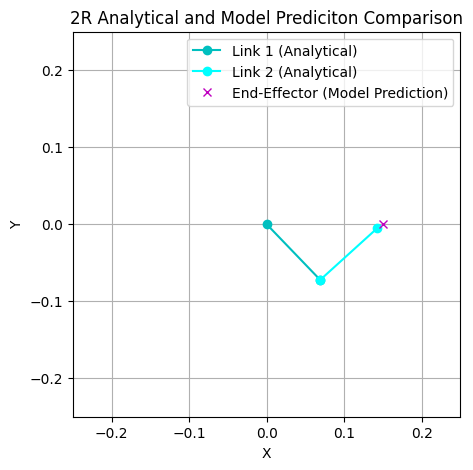

In [244]:
target_position = [0.15, 0] 
initial_guess = [np.pi/4, np.pi/2]  

theta_solution = IK_Newton_Raphson(target_position, initial_guess, model_2R)

result_model = FK(model_2R, theta_solution)  
dispFK_2R(result_model, theta_solution)

### 2) 2D with 3 joints

===== Step n°0 =====
Current Position: [ 0.26920885 -0.04051924]
Intermediate joint angles: [-0.7853982  0.5235988  0.7853982]

===== Step n°1 =====
Current Position: [-0.12031287 -0.15491354]
Intermediate joint angles: [-2.536435   1.5861875  4.2290087]

===== Step n°2 =====
Current Position: [-0.06576879 -0.03601221]
Intermediate joint angles: [-3.1385005  1.5573317  2.3504639]

===== Step n°3 =====
Current Position: [-0.00155373  0.01149487]
Intermediate joint angles: [-3.6519055  2.515501   2.8236346]

===== Step n°4 =====
Current Position: [ 0.01976012 -0.01128102]
Intermediate joint angles: [-1.2160175  2.9059114  2.6247368]

===== Step n°5 =====
Current Position: [-0.0219894   0.08668955]
Intermediate joint angles: [-0.9763148  2.4651935  1.5696619]

===== Step n°6 =====
Current Position: [-0.02203732  0.02396896]
Intermediate joint angles: [-2.7854195  2.1770904  2.422491 ]

===== Step n°7 =====
Current Position: [-0.00969335  0.0393249 ]
Intermediate joint angles: [-2.5834775 

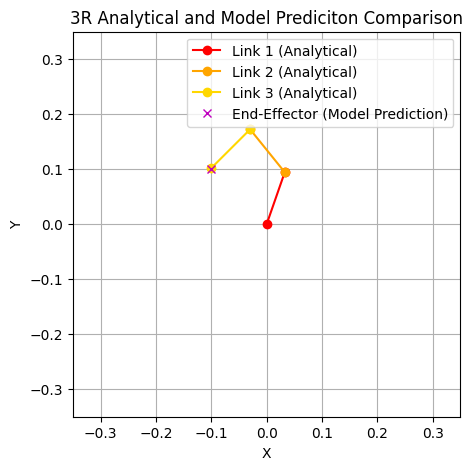

In [234]:
target_position = [-0.1, 0.1] 
initial_guess = [-np.pi/4, np.pi/6, np.pi/4]  

theta_solution = IK_Newton_Raphson(target_position, initial_guess, model_3R)

result_model = FK(model_3R, theta_solution)  
dispFK_3R(result_model, theta_solution)

## V - Robot Control 

In [ ]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, dt):
        self.kp = Kp
        self.ki = Ki
        self.kd = Kd
        self.dt = dt
        self.prev_error = 0
        self.integral = 0

    def update_control(self, target, current):
        """
        Computes the control action using the PID.
        @param target: The target angle value
        @param current: The current angle value
        """
        error = target - current
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt

        control = self.kp * error + self.ki * self.integral + self.kd * derivative
        self.prev_error = error

        return control

### 1) 2D with 2 joints

### 2) 2D with 3 joints